# NLP - Assignment 2

## Imports

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import gensim
from gensim import corpora



c:\Users\charl\anaconda3\envs\nlp-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [2]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv("./us_equities_news_dataset.csv")
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [3]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]


In [4]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, 
                    remove_punctuation=True, 
                    remove_stopwords=True, 
                    lemmatize=False, 
                    stem=False, 
                    remove_short_words=False, 
                    remove_rare_words=False, 
                    remove_numbers=True, 
                    min_word_length=2):
    """
    Advanced preprocessing function that applies different levels of text processing.
    
    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - stem: Whether to apply stemming to reduce words to their base form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_rare_words: Whether to remove rare words based on the dataset distribution.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.
    
    Returns:
    - Preprocessed text as tokens.
    """
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]
    
    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Stemming (alternative to lemmatization)
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]
    
    return tokens

In [5]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.
    
    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').
    
    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """
    
    if version == 'v1':
        # Basic tokenization and lowercasing
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=False, remove_stopwords=False, 
            lemmatize=False, remove_numbers=False, stem=False, 
            remove_short_words=False
        ))
    
    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=False, remove_numbers=False, stem=False, 
            remove_short_words=False
        ))
    
    elif version == 'v3':
        # Advanced preprocessing with stemming, number removal, short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=False, stem=True, remove_numbers=True, 
            remove_short_words=True, min_word_length=2
        ))
    
    elif version == 'v4':
        # Full preprocessing with lemmatization instead of stemming, number removal, and short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True, 
            lemmatize=True, remove_numbers=True, stem=False, 
            remove_short_words=True, min_word_length=2
        ))
    
    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3', or 'v4'.")
    
    # Return the DataFrame with original and preprocessed content
    return nvidia_dataset


In [6]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with stemming
train_data_v4 = apply_preprocessing(nvidia_dataset, version='v4')  # Full preprocessing with lemmatizer

In [7]:
train_data_v1.head()

,id,ticker,title,category,content,release_date,provider,url,article_id,preprocessed_content
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,ECB Effects\nThe move in the euro was huge fa...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,"[ecb, effect, move, euro, huge, falling, pip, ..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch March 6 Trading Session\nSt...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,"[stock, watch, march, trading, session, stock,..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Investing com A rout in Apple and Facebook ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,"[investing, com, rout, apple, facebook, nasdaq..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,For Immediate ReleaseChicago IL January 13 ...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,"[immediate, releasechicago, il, january, zacks..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,With 4 500 companies bringing their innovation...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,"[company, bringing, innovation, ce, jan, get, ..."


In [8]:
# train_data_head = train_data_v1.head()

# # Specify the filename for the Excel file
# output_file = 'train_data_v1_head.xlsx'

# # Save to Excel
# train_data_head.to_excel(output_file, index=False)

## Train Topic Models

In [9]:
def compute_coherence_values(train_data_list, dictionary, max_topics=20):
    """
    Compute coherence values for different numbers of topics in LDA model.

    Parameters:
    - train_data_list: List of tokenized documents.
    - dictionary: Gensim dictionary.
    - max_topics: Maximum number of topics to test.

    Returns:
    - coherence_values: List of coherence values for each number of topics.
    - optimal_num_topics: The optimal number of topics based on maximum coherence.
    """

    # Create Document-Term Matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list]

    coherence_values = []
    
    # Iterate over different numbers of topics
    for num_topics in range(2, max_topics + 1):
        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        # Compute coherence score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=train_data_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    # Find the optimal number of topics (maximum coherence)
    optimal_num_topics = coherence_values.index(max(coherence_values)) + 2  # +2 because range starts from 2

    return coherence_values, optimal_num_topics

In [10]:
def plot_coherence_scores(coherence_values, max_topics):
    """
    Plot the coherence scores to visualize the elbow method.

    Parameters:
    - coherence_values: List of coherence values.
    - max_topics: Maximum number of topics tested.
    """
    x = range(2, max_topics + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, coherence_values, marker='o')
    plt.title('Coherence Scores vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(x)
    plt.grid()
    plt.show()

In [11]:
def train_topic_model(train_data, model_type='LDA', max_topics=20):
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: DataFrame containing preprocessed text data
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - max_topics: int, maximum number of topics to test for coherence

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    """

    # Extract tokenized documents as a list of lists
    train_data_list_tokens = train_data['preprocessed_content'].tolist()  # This should already be a list of lists
    train_data_list_string = [' '.join(tokens) for tokens in train_data['preprocessed_content']]


    if model_type == 'LDA':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)
        
        # Compute coherence values and find optimal number of topics
        coherence_values, optimal_num_topics = compute_coherence_values(train_data_list_tokens, dictionary, max_topics)

        # Plot coherence scores
        plot_coherence_scores(coherence_values, max_topics)

        # Create Document-Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list_tokens]

        # Train LDA model with optimal number of topics
        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=optimal_num_topics,
            id2word=dictionary,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        # Get topics (top words in each topic)
        topics = lda_model.print_topics(num_words=10)

        return lda_model, topics
    
    elif model_type == 'FLSA-W':
        # Replace with actual FLSA-W training code
        flsa_w_model = None
        topics = None
        
        return flsa_w_model, topics
    
    elif model_type == 'BERTopic':
        # Train BERTopic model
        topic_model = BERTopic(nr_topics=10)
        topics, _ = topic_model.fit_transform(train_data_list_string)
        
        return topic_model, topics

## Iteration 1

### LDA

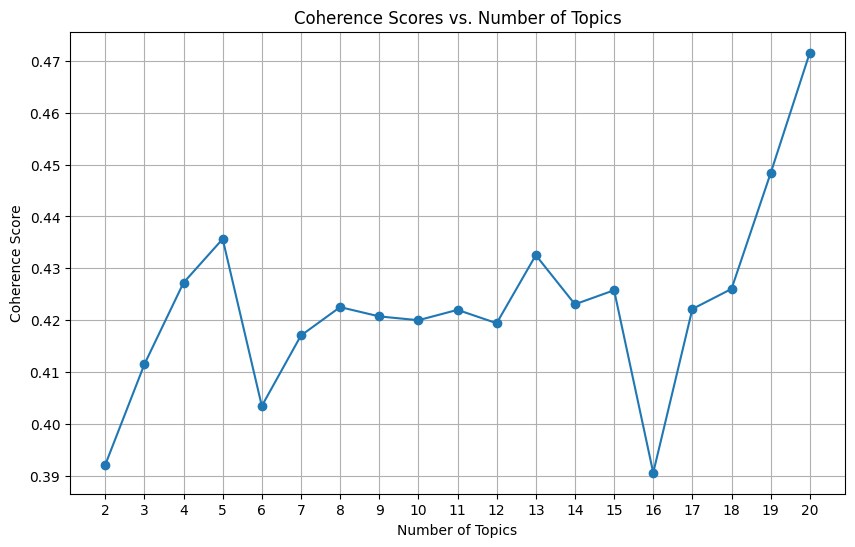

(0, '0.028*"tsmc" + 0.021*"said" + 0.021*"samsung" + 0.017*"chip" + 0.017*"taiwan" + 0.014*"infineon" + 0.013*"manufacturing" + 0.012*"smartphone" + 0.012*"semiconductor" + 0.010*"co"')
(1, '0.027*"year" + 0.026*"quarter" + 0.021*"company" + 0.020*"zacks" + 0.018*"revenue" + 0.015*"earnings" + 0.015*"million" + 0.012*"stock" + 0.012*"estimate" + 0.010*"growth"')
(2, '0.015*"oil" + 0.010*"index" + 0.010*"dollar" + 0.010*"price" + 0.010*"week" + 0.010*"higher" + 0.009*"market" + 0.009*"expected" + 0.009*"data" + 0.007*"lower"')
(3, '0.039*"biotech" + 0.034*"projected" + 0.023*"disease" + 0.018*"climb" + 0.014*"surge" + 0.014*"amat" + 0.013*"help" + 0.012*"genome" + 0.012*"applied" + 0.012*"biology"')
(4, '0.019*"analyst" + 0.013*"company" + 0.012*"report" + 0.012*"zacks" + 0.012*"share" + 0.009*"growth" + 0.009*"year" + 0.009*"micron" + 0.008*"revenue" + 0.008*"sale"')
(5, '0.016*"company" + 0.010*"apple" + 0.009*"technology" + 0.008*"driving" + 0.008*"car" + 0.007*"nasdaq" + 0.007*"vehi

In [15]:
LDA_model, LDA_topics = train_topic_model(train_data_v1, model_type='LDA', max_topics=20)

# Print topics
for topic in LDA_topics:
    print(topic)

### FLSA-W

### BERTopic

In [69]:
# Train BERTopic model on the first version of the preprocessed dataset
# num_topics is maximum number of topics rather than a fixed number of topics
bertopic_model, bertopic_topics = train_topic_model(train_data_v1, model_type='BERTopic', num_topics=10)


## Iteration 2

## Iteration 3

## Iteration ....

## Evaluation

### Qualitative

### Quantitative

## Output of Final Topic Model